# DBTL 7 data analysis

This notebook analyzes OD340 data from DBTL cycle 7 of a flaviolin producing P. putida.

## Inputs and outputs

#### Required file to run this notebook:
   - edd slug


#### File generated by running this notebook:
   
 
    
The files are stored in the user defined directory.

## Setup

Importing needed libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from sklearn.metrics import r2_score

import edd_utils as eddu

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from art.core import *
# import art.plot as plot

/opt/conda/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


### User parameters

In [3]:
CYCLE = 7

user_params = {
    'output_file_path': f'../data/DBTL{CYCLE}', # Folder for output files,
    'bounds_file': f'../data/Putida_media_bounds_extended.csv',
    'study_slug': 'combinatorial-media-for-flaviolin-dbtl-7',
    'edd_server': 'edd.jbei.org',
    'username': 'tradivojevic',
    } 

In [4]:
study_slug = user_params['study_slug']
edd_server = user_params['edd_server']
username = user_params['username']

## Load the study

In [6]:
try:
  session = eddu.login(edd_server=edd_server, user=username)
except:
  print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
  print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for tradivojevic:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


In [135]:
df: pd.DataFrame
    
try:
    df = eddu.export_study(session, study_slug, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    try:
        df = pd.read_csv(user_params['study_file'])
    except:
        print(f'ERROR! Alternative loading of data from disk failed!')
    else:
        print(f'OK! Alternative loading of data from disk was successful.')


100%|██████████| 48/48 [00:00<00:00, 1595.06it/s]


In [136]:
df.head()

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,173217,Combinatorial media for flaviolin DBTL 7,173218,d7341daf-8208-4880-948a-9592fe69baa3,C7_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,173266,C7_WA1_C1-R1,NaN,OD340,0,NaN,0.0309,48.0
1,173217,Combinatorial media for flaviolin DBTL 7,173219,7fe64521-5051-4904-a562-05e7cacc7f15,C7_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,173267,C7_WA1_C1-R2,NaN,OD340,0,NaN,0.0222,48.0
2,173217,Combinatorial media for flaviolin DBTL 7,173220,5099b1f6-d265-4cd3-9580-cd5cbd692e34,C7_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,173268,C7_WA1_C1-R3,NaN,OD340,0,NaN,0.0154,48.0
3,173217,Combinatorial media for flaviolin DBTL 7,173221,f2e3626c-163c-4594-8c52-b0d12a61697b,C7_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,173269,C7_WD1_F1-R1,NaN,OD340,0,NaN,0.0035,48.0
4,173217,Combinatorial media for flaviolin DBTL 7,173222,401c56a1-4362-4d1f-ba1e-b1c9158d7535,C7_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,173270,C7_WD1_F1-R2,NaN,OD340,0,NaN,0.0000,48.0


Drop unnecessary columns:

In [137]:
df = df.loc[:,['Line Name','Line Description','Measurement Type','Value']]
df.head()

,Line Name,Line Description,Measurement Type,Value
0,C7_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.0309
1,C7_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.0222
2,C7_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.0154
3,C7_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.0035
4,C7_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,0.0000


In [138]:
find_col = lambda x: x['Line Name'][5]

def find_row(row):
    line_name = row['Line Name']
    if line_name[4] == 'A':
        if int(line_name[-1]) == 1:
            return "A"
        elif int(line_name[-1]) == 2:
            return "B"
        else:
            return "C"
    else:
        if int(line_name[-1]) == 1:
            return "D"
        elif int(line_name[-1]) == 2:
            return "E"
        else:
            return "F"


In [139]:
df['Row'] =  df.apply(find_row, axis=1)
df['Column'] =  df.apply(find_col, axis=1)


## Coefficient of variation

In [13]:
df_red = df.drop(columns=['Column'])
stats = df_red.groupby(['Measurement Type', 'Line Description']).mean()
stats.rename(columns={'Value': 'mean'}, inplace=True)
stats['std'] = df_red.groupby(['Measurement Type', 'Line Description']).std()
stats['CV[%]'] = 100* stats['std'] / stats['mean']
stats

/tmp/ipykernel_95/494067325.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stats = df_red.groupby(['Measurement Type', 'Line Description']).mean()
/tmp/ipykernel_95/494067325.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stats['std'] = df_red.groupby(['Measurement Type', 'Line Description']).std()


mean  \
Measurement Type Line Description                                               
OD340            MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.280367   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.400633   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.015433   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.197733   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.008433   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.030900   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.022833   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.021400   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.000667   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.028067   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.011433   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.764200   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.051567   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.030667   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.000000   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.001167   

                                                                          std  \
Measurement Type Line Description                                               
OD340            MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.018801   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.029079   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.002250   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.011793   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.002122   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.006798   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.007769   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.003650   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.001155   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.009849   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.005519   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.053025   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.004352   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.002155   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.000000   
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  0.002021   

                                                                          CV[%]  
Measurement Type Line Description                                                
OD340            MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...    6.705726  
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...    7.258237  
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...   14.580034  
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...    5.963846  
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...   25.163311  
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...   21.999333  
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...   34.026501  
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...   17.054474  
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...  173.205081  
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...   35.091545  
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...   48.274285  
                 MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3B...    6.938616  
       

In [14]:
print("Mean coefficient of variation for OD340:")
np.mean(stats.loc['OD340','CV[%]'])

Mean coefficient of variation for OD340:


38.99553618513311

## Visualization

/tmp/ipykernel_95/1875209016.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df,


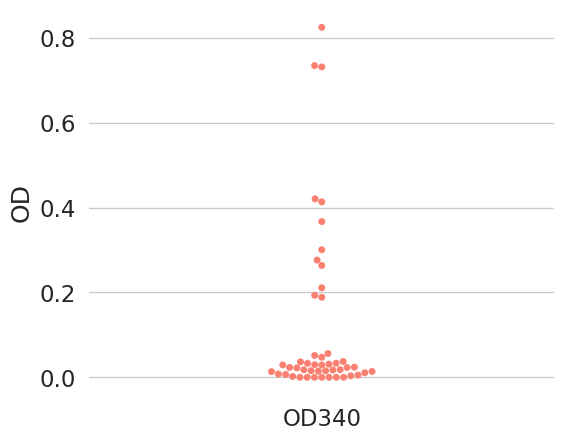

In [16]:
fig, ax = plt.subplots(figsize=(6, 5))
fontsize = 16
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
sns.swarmplot(data=df, 
              linewidth=0,
              x='Measurement Type',
              y='Value',
              palette="dark:salmon_r"
              )
sns.despine(left=True, bottom=True)
ax.set(xlabel=None, ylabel="OD")

fig.savefig(
    f"{user_params['output_file_path']}/swarm_both.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

Per line:

In [17]:
line_names = []
df_340 = df[df['Measurement Type']=='OD340'].reset_index()
for i in range(int(len(df_340)/3)):
    line_names.append(str(df_340['Line Name'][3*i])[3:-3])
# line_names

/tmp/ipykernel_95/2548742498.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(line_names, fontsize=8, rotation = 30)


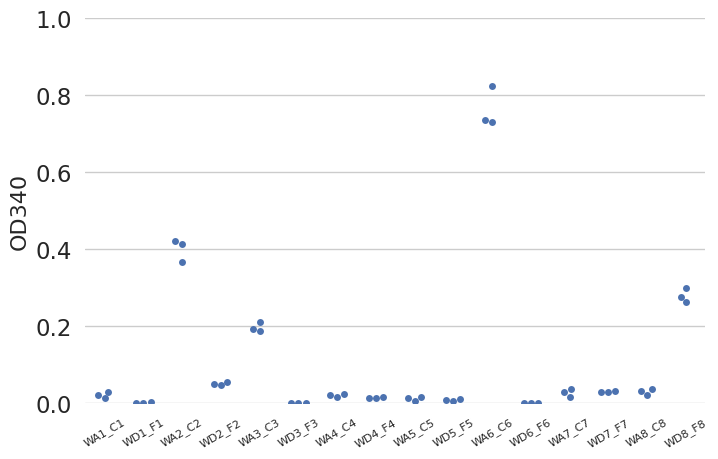

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))
fontsize = 14
sns.set_style("whitegrid")
g = sns.swarmplot(data=df, 
              linewidth=0,
              x='Line Description',
              y='Value',
              # hue='Measurement Type',
              # palette="dark:salmon_r",
              )
g.set_xticklabels(line_names, fontsize=8, rotation = 30)
# plt.legend(fontsize=fontsize)
sns.despine(left=True, bottom=True)
ax.set_ylabel("OD340", fontsize=fontsize+2)
ax.set_xlabel(None)
plt.ylim([0, 1.])

fig.savefig(
    f"{user_params['output_file_path']}/swarm_per_design.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

### Plot OD measurements per well

In [25]:
data_od340 = df[df['Measurement Type']=='OD340'].pivot('Row', 'Column')['Value']

/tmp/ipykernel_95/879626712.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data_od340 = df[df['Measurement Type']=='OD340'].pivot('Row', 'Column')['Value']


In [133]:
data_od340.head()

Column,1,2,3,4,5,6,7,8
Row,,,,,,,,
A,0.0309,0.3673,0.1888,0.0238,0.0134,0.7352,0.0373,0.0364
B,0.0222,0.4138,0.2111,0.0232,0.0157,0.7320,0.0292,0.0330
C,0.0154,0.4208,0.1933,0.0172,0.0052,0.8254,0.0177,0.0233
D,0.0035,0.0560,0.0020,0.0180,0.0108,0.0000,0.0331,0.2638
E,0.0000,0.0514,0.0000,0.0145,0.0078,0.0000,0.0299,0.2765


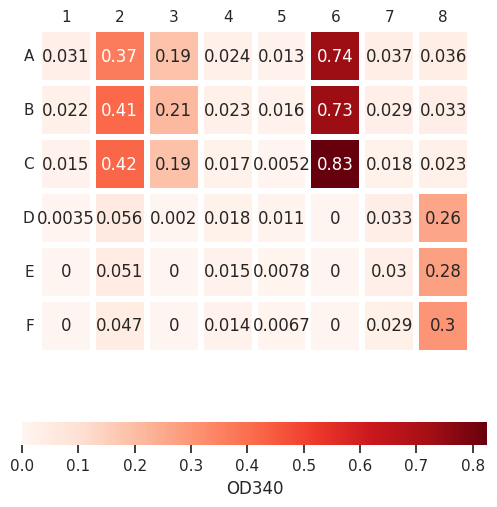

In [26]:
fig = plt.figure(figsize=(10,6))
colormap = sns.color_palette("light:salmon", as_cmap=True)
colormap = "Reds"
sns.set_context("notebook", font_scale=1., rc={"lines.linewidth": 2.5})
ax = sns.heatmap(data_od340, 
                 linewidths=3, 
                 linecolor="w",
                 square= True,
                 cmap=colormap,
                 cbar_kws={"orientation": "horizontal",
                           "shrink": 0.6,
                           'label': 'OD340'
                          },
                 annot = True,
                )
ax.set(xlabel=None, ylabel=None)
plt.yticks(rotation=0)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
fig.savefig(
    f"{user_params['output_file_path']}/OD340.png",
    transparent=False,
    bbox_inches="tight",
    dpi=300,
)

### Load training data and predictions for recommendations:

In [27]:
user_params['target_designs'] = f"{user_params['output_file_path']}/target_concentrations.csv"

In [28]:
designs_pred = pd.read_csv(user_params['target_designs'], index_col=0).reset_index()
designs_pred.drop(columns='Well', inplace=True)
designs_pred['OD340'] = df[df['Measurement Type']=='OD340']['Value'].values
designs_pred.head()

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],Label,OD340_pred,OD340_std,OD340
0,0.033485,157.760522,0.964123,6.992958,0.067892,23.233056,1.932010,1313.377579,0.000108,0.002725,0.004785,0.007395,0.001752,0.035968,LHS,0.566117,0.094277,0.0309
1,0.033485,157.760522,0.964123,6.992958,0.067892,23.233056,1.932010,1313.377579,0.000108,0.002725,0.004785,0.007395,0.001752,0.035968,LHS,0.566117,0.094277,0.0222
2,0.033485,157.760522,0.964123,6.992958,0.067892,23.233056,1.932010,1313.377579,0.000108,0.002725,0.004785,0.007395,0.001752,0.035968,LHS,0.566117,0.094277,0.0154
3,0.073964,197.001031,0.805718,8.730541,0.024996,34.480900,1.287242,959.379367,0.000295,0.001569,0.005873,0.013567,0.000728,0.016770,LHS,0.590909,0.097057,0.0035
4,0.073964,197.001031,0.805718,8.730541,0.024996,34.480900,1.287242,959.379367,0.000295,0.001569,0.005873,0.013567,0.000728,0.016770,LHS,0.590909,0.097057,0.0000


In [31]:
user_params['train_data'] = f'../data/DBTL{CYCLE}/train_pred.csv'

In [32]:
train_pred = pd.read_csv(user_params['train_data'], index_col=0)
train_pred

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340,OD340_pred,OD340_std,OD340_cv_pred,OD340_cv_std,Label
0,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0,0.4422,0.378035,0.062557,0.374855,0.066082,train
1,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0,0.3405,0.378035,0.062557,0.374855,0.066082,train
2,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0,0.3397,0.378035,0.062557,0.374855,0.066082,train
3,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0,0.3602,0.378035,0.062557,0.374855,0.066082,train
4,0.009185,20.0,0.380499,1.156774,0.007971,11.618192,5.030266,50.607910,0.000155,0.000152,0.000029,0.000410,0.000277,0,0.2699,0.270589,0.062521,0.255072,0.065875,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.034219,20.0,0.487692,5.964381,0.078645,9.187989,2.424902,103.608502,0.000248,0.001288,0.000352,0.000772,0.000867,0,0.3230,0.334129,0.062534,0.384584,0.065443,train
284,0.034219,20.0,0.487692,5.964381,0.078645,9.187989,2.424902,103.608502,0.000248,0.001288,0.000352,0.000772,0.000867,0,0.3304,0.334129,0.062534,0.384584,0.065443,train
285,0.003968,20.0,0.278836,1.196387,0.010759,10.408408,0.475231,51.200970,0.000028,0.000316,0.000091,0.000777,0.000103,0,0.2993,0.291546,0.062516,0.279163,0.061648,standard
286,0.003968,20.0,0.278836,1.196387,0.010759,10.408408,0.475231,51.200970,0.000028,0.000316,0.000091,0.000777,0.000103,0,0.3000,0.291546,0.062516,0.279163,0.061648,standard


In [33]:
def predictions_vs_observations(
    designs,
    train,
    errorbars_flag=False,
    xlim=None,
    ylim=None,
):
    
    plt.style.use("seaborn-white")

    fontsize = 20

    fig, ax = plt.subplots(figsize=(7, 7))
    
    obs_all = np.append(train['OD340'], designs['OD340'])
    pred_all = np.append(train['OD340_cv_pred'], designs['OD340_pred'])
    pred_std_all = np.append(train['OD340_cv_std'], designs['OD340_std'])
   
    
    # Plot Scatter Plot
    if errorbars_flag:
        plt.errorbar(
            obs_all,
            pred_all,
            yerr=1.96 * pred_std_all,
            fmt='none',
            ecolor="lightgray",
            elinewidth=1,
            alpha=0.5,
            zorder=0
        )
            
    plt.scatter(
        train['OD340'], 
        train['OD340_cv_pred'], 
        color="gray",
        label='train'
    )

    standard = train[train['Label']=='standard']
    plt.scatter(
        standard['OD340'], 
        standard['OD340_cv_pred'],
        label='standard',
        color="k"
    )
    
    standard_des = designs[designs['Label']=='standard']
    plt.scatter(standard_des['OD340'], standard_des['OD340_pred'], color="k")
    
    exploit_des = designs[designs['Label']=='exploitation']
    plt.scatter(
        exploit_des['OD340'], 
        exploit_des['OD340_pred'], 
        color="r",
        label='exploitation'
    )
    
    lhs_des = designs[designs['Label']=='LHS']
    plt.scatter(
        lhs_des['OD340'], 
        lhs_des['OD340_pred'], 
        color="orange",
        label='LHS'
    )
    
    r2_train = round(r2_score(train['OD340'], train['OD340_cv_pred']), 2)
    
    r2_all = round(r2_score(obs_all, pred_all), 2)

    ax.set_title(f"$R^2$={r2_train}", fontsize=fontsize)
    
    print(f"$R^2$={r2_all}")
    ax.set_xlabel("Observations", fontsize=fontsize)
    ax.set_ylabel("Cross-validation predictions", fontsize=fontsize)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    if xlim is None:
        ax.set_xlim(lims)
    else:
        ax.set_xlim(xlim)

    if ylim is None:
        ax.set_ylim(lims)
    else:
        ax.set_ylim(ylim)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    
    plt.legend(loc='best', 
               fontsize=fontsize-4)

    plt.tick_params(axis="both", which="major", labelsize=fontsize)
    plt.show()

    fig.savefig(
        user_params['output_file_path']
        + "/predictions_vs_observations.png",
        bbox_inches="tight",
        transparent=False,
        dpi=300,
    )

    plt.close(fig)

/tmp/ipykernel_95/2323883597.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


$R^2$=-0.08


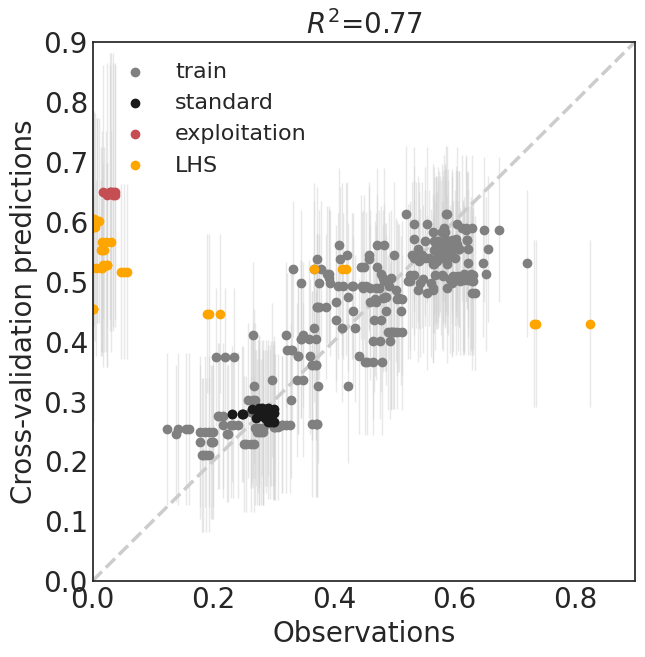

In [34]:
predictions_vs_observations(
    designs=designs_pred,
    train=train_pred,
    errorbars_flag=True,
    xlim=[0., 0.9],
    ylim=[0., 0.9],
)

## Inspect designs

In [69]:
df_all = train_pred.drop(
    columns=['OD340_pred','OD340_std', 'OD340_cv_pred', 'OD340_cv_std']
)
df_all = df_all.append(
    designs_pred.drop(
        columns=['OD340_pred','OD340_std']
    )
).reset_index(drop=True)

/tmp/ipykernel_95/530199538.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(


In [89]:
df_all['OD340_yield'] = df_all['OD340']/df_all['Glucose[mM]']

In [90]:
df_all.head()

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340,Label,OD340_yield
0,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.0,0.4422,train,0.022110
1,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.0,0.3405,train,0.017025
2,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.0,0.3397,train,0.016985
3,0.003744,20.0,0.029492,3.995413,0.042847,6.490478,0.214493,197.916509,0.000016,0.000254,0.000309,0.006371,0.000866,0.0,0.3602,train,0.018010
4,0.009185,20.0,0.380499,1.156774,0.007971,11.618192,5.030266,50.607910,0.000155,0.000152,0.000029,0.000410,0.000277,0.0,0.2699,train,0.013495


In [91]:
titer_max_ind = df_all['OD340'].nlargest(3).index
df_all.loc[titer_max_ind]

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340,Label,OD340_yield
320,0.057934,110.380997,0.286511,6.340137,0.093384,14.362711,0.068484,163.127011,0.000497,0.005057,0.004057,0.015413,0.000938,0.022207,0.8254,LHS,0.007478
318,0.057934,110.380997,0.286511,6.340137,0.093384,14.362711,0.068484,163.127011,0.000497,0.005057,0.004057,0.015413,0.000938,0.022207,0.7352,LHS,0.006661
319,0.057934,110.380997,0.286511,6.340137,0.093384,14.362711,0.068484,163.127011,0.000497,0.005057,0.004057,0.015413,0.000938,0.022207,0.7320,LHS,0.006632


In [104]:
yield_max_ind = df_all['OD340_yield'].nlargest(1).index
df_all.loc[yield_max_ind]

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340,Label,OD340_yield
96,0.028304,20.0,0.203775,2.142815,0.04985,10.682077,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0.0,0.7206,train,0.03603


In [113]:
df_all.loc[int((yield_max_ind).values):int((yield_max_ind).values)+2]

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],CaCl2[mM],OD340,Label,OD340_yield
96,0.028304,20.0,0.203775,2.142815,0.04985,10.682077,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0.0,0.7206,train,0.036030
97,0.028304,20.0,0.203775,2.142815,0.04985,10.682077,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0.0,0.6227,train,0.031135
98,0.028304,20.0,0.203775,2.142815,0.04985,10.682077,1.327616,400.020175,0.000282,0.001039,0.000786,0.002639,0.000014,0.0,0.6467,train,0.032335


In [116]:
titer_max = df_all.loc[titer_max_ind]['OD340'].mean()
yield_max = (
    df_all.loc[int((yield_max_ind).values):int((yield_max_ind).values)+2]['OD340_yield']
).mean()

In [117]:
titer_max, yield_max

(0.7642000000000001, 0.03316666666666667)

In [119]:
titer_standard = df_all[df_all['Label']=='standard']['OD340'].mean()
yield_standard = df_all[df_all['Label']=='standard']['OD340_yield'].mean()
titer_standard, yield_standard

(0.2817521739130435, 0.014025777618754504)

In [121]:
improvement = 100*(titer_max/titer_standard-1)
f'Improvement in titer over the control: {improvement:.2f}%'


'Improvement in titer over the control: 171.23%'

In [122]:
improvement = 100*(yield_max/yield_standard-1)
f'Improvement in yield over the control: {improvement:.2f}%'

'Improvement in yield over the control: 136.47%'

In [124]:
df_all = df_all.drop(columns=['Label'])


In [125]:
df_high = df_all[df_all['OD340_yield'] >= 0.015]
df_low = df_all[df_all['OD340_yield'] <= 0.015]

In [126]:
len(df_high), len(df_low)

(219, 118)

In [127]:
df_bounds = pd.read_csv(user_params['bounds_file'])

In [129]:
def designs_pairwise(df_high, df_low, bounds):

    components = df_high.columns[:-2]
    dim = len(components)
#     print(f'dim={dim}')

    plt.style.use('seaborn-whitegrid')

    fig = plt.figure(figsize=(35, 35))
    fig.patch.set_facecolor("white")

    X_high = df_high[components].values
    X_low = df_low[components].values

    for var1 in range(dim):
        for var2 in range(var1 + 1, dim):

            ax = fig.add_subplot(dim, dim, (var2 * dim + var1 + 1))
            
            ax.scatter(
                X_high[:, var1],
                X_high[:, var2],
                c="g",
                marker="+",
                s=150*df_high['OD340'],
                lw=1,
                label="high",
            )
            ax.scatter(
                X_low[:, var1],
                X_low[:, var2],
                c="r",
                marker="+",
                s=150*df_low['OD340'],
                lw=1,
                label="low",
            )
            xlims = np.asarray([
                bounds[bounds['Variable']==components[var1]]['Min'],
                bounds[bounds['Variable']==components[var1]]['Max']
            ])
            ylims = np.asarray([
                bounds[bounds['Variable']==components[var2]]['Min'],
                bounds[bounds['Variable']==components[var2]]['Max']
            ])
            ax.set_xlim(xlims)
            ax.set_ylim(ylims)
                        
            if var2 == (dim - 1):
                ax.set_xlabel(components[var1])
            if var1 == 0:
                ax.set_ylabel(components[var2])
                if var2 == 0:
                    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), shadow=True)

    fig.savefig(
        f'{user_params["output_file_path"]}/designs_pairwise_high.png',
        bbox_inches="tight",
        transparent=False, 
        dpi=300
    )

/tmp/ipykernel_95/167804487.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


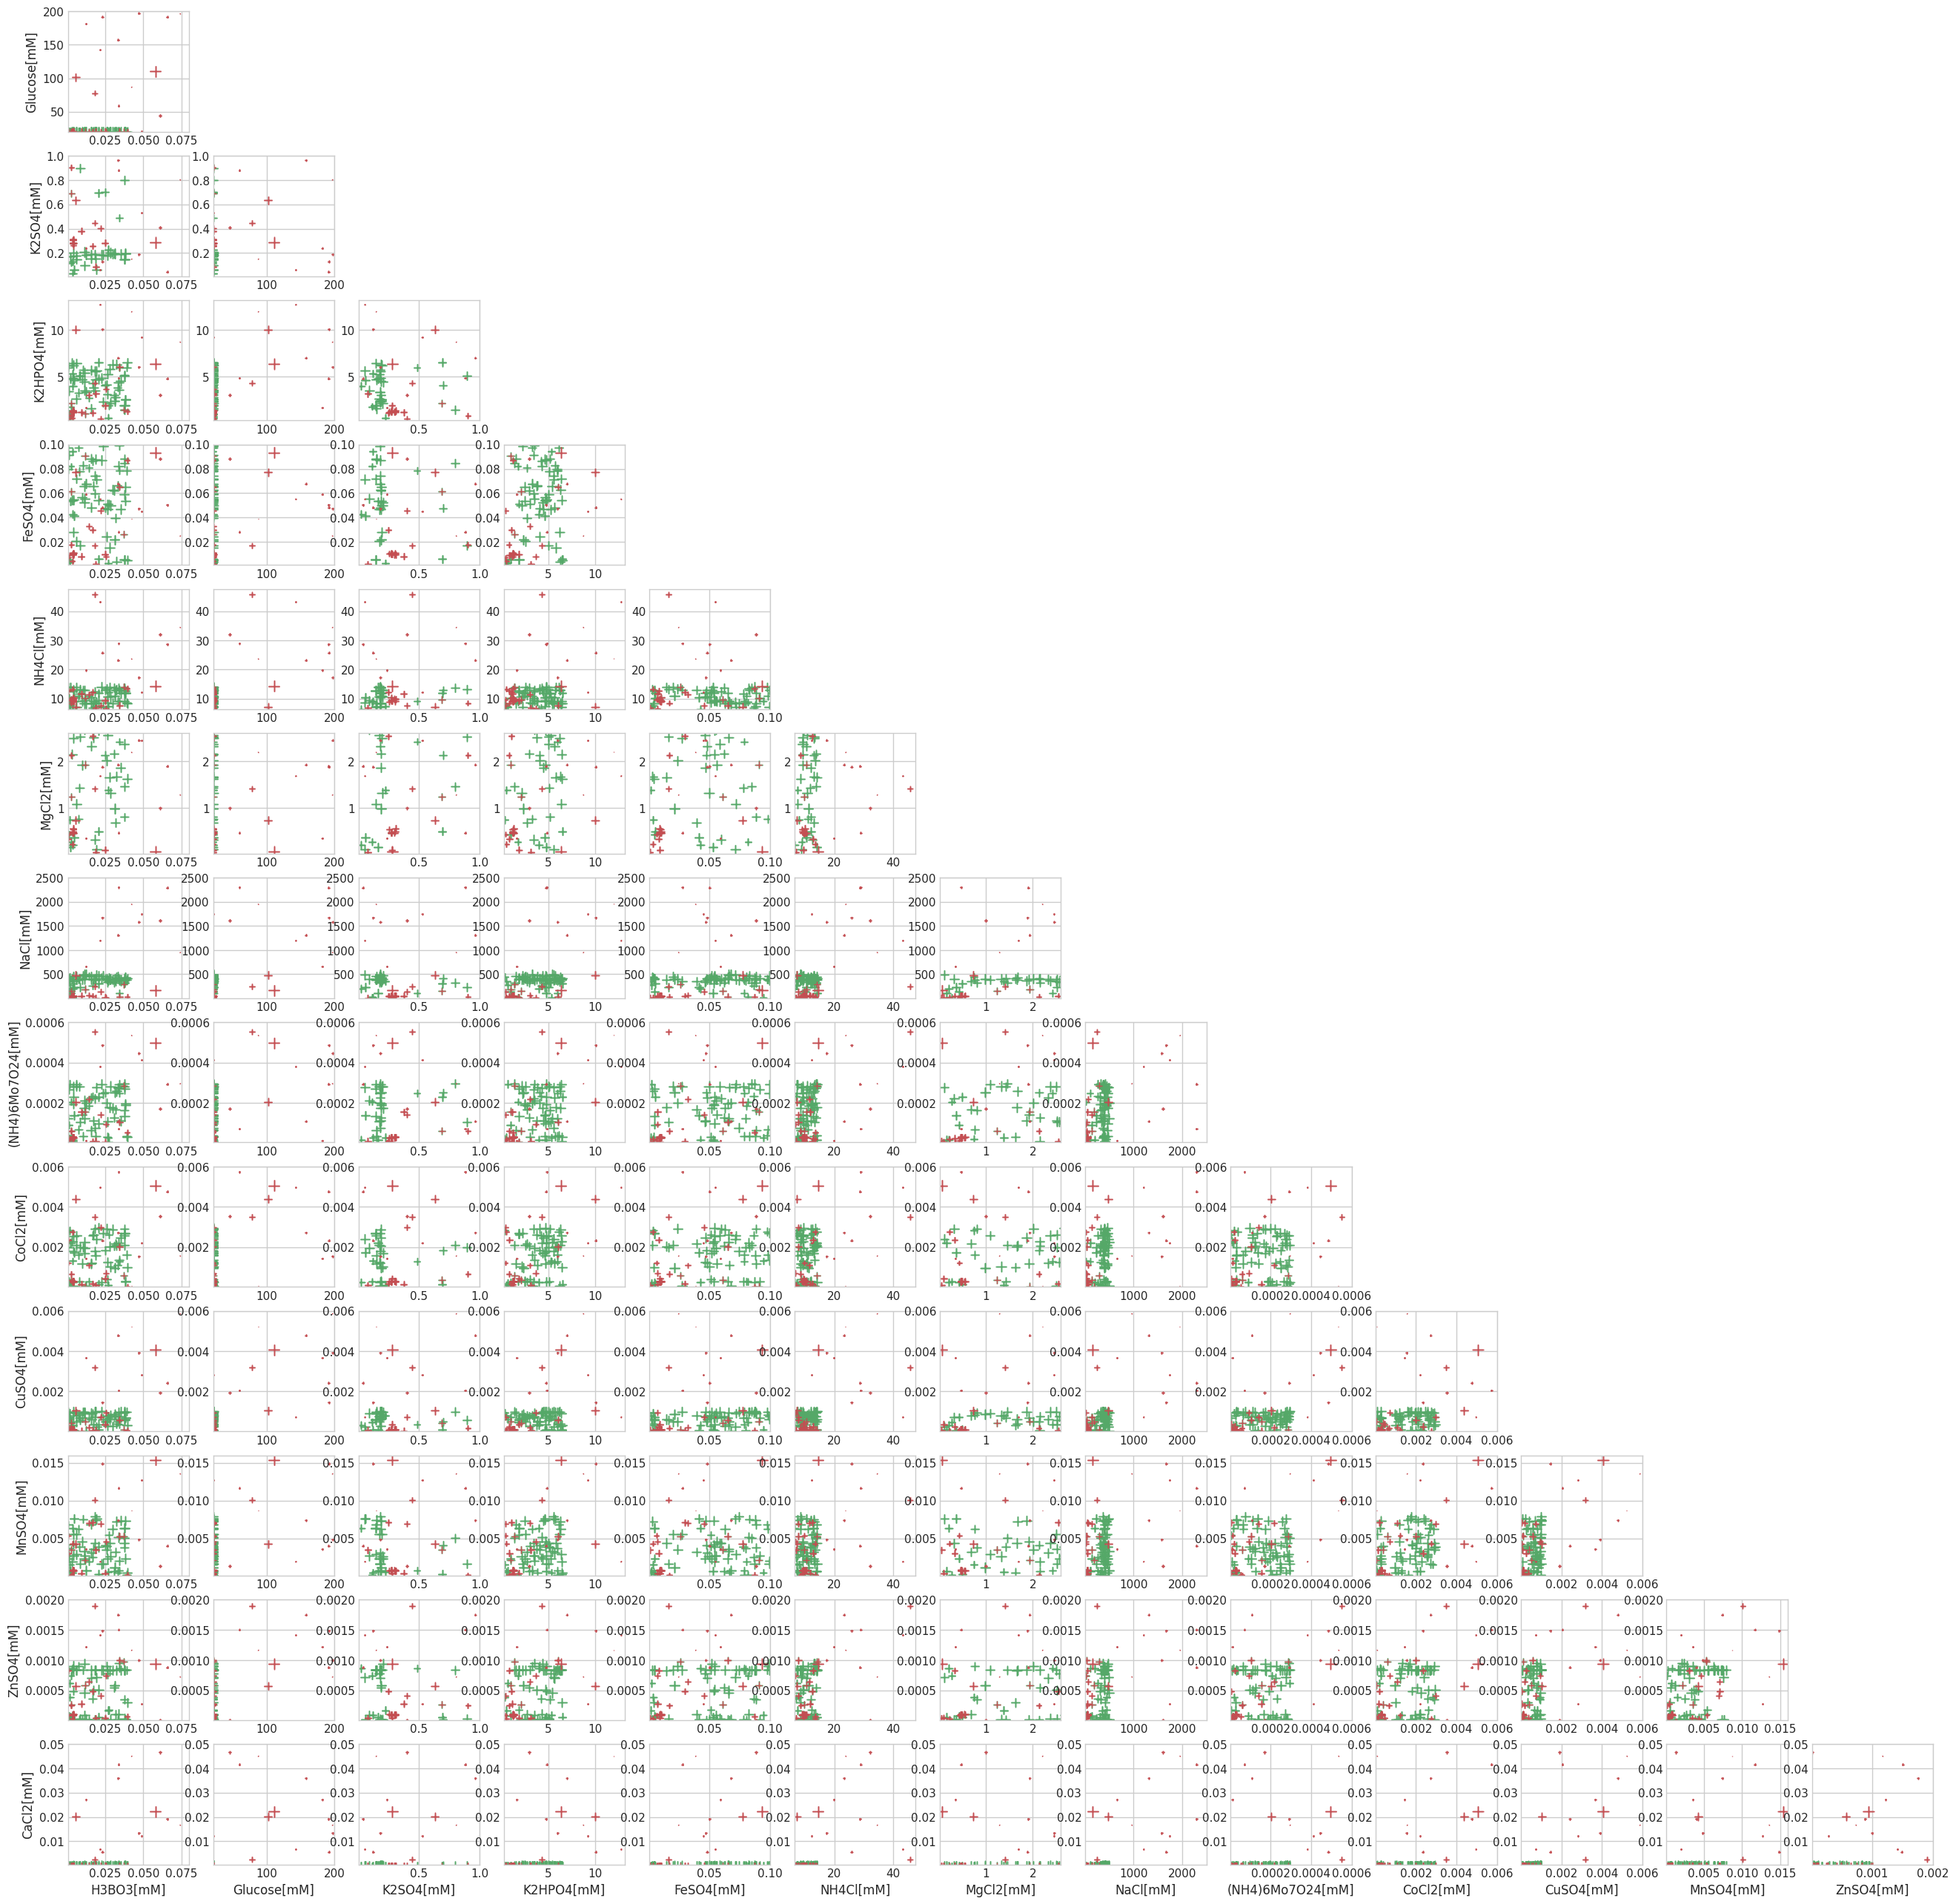

In [130]:
designs_pairwise(df_high, df_low, df_bounds)

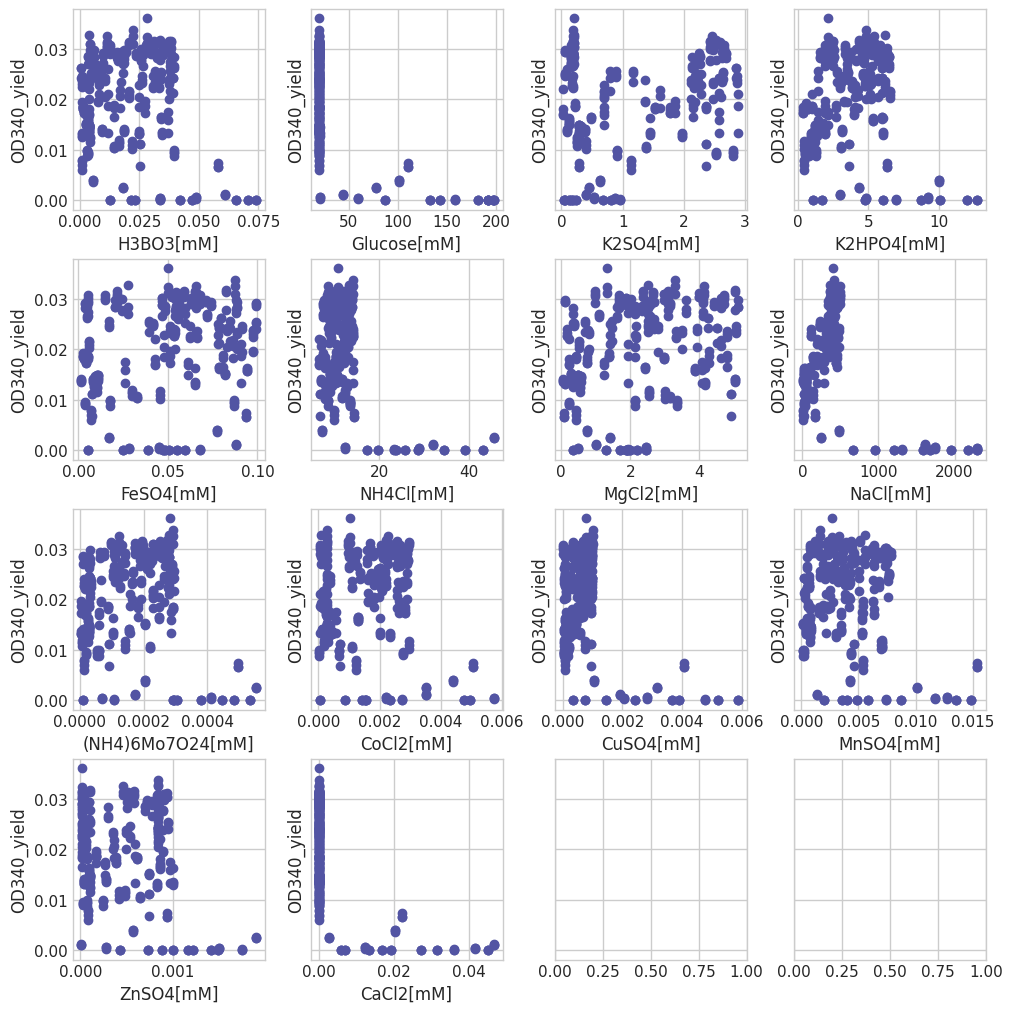

In [131]:
from matplotlib import cm
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10,10), sharey=True, constrained_layout=True)

cmap_name = 'tab20b'
colors = cm.get_cmap(cmap_name)

components = df_all.columns[:-2]

for component, ax in zip(components, axs.ravel()[:-2]):
    ax.scatter(
        df_all[component], 
        df_all['OD340_yield'], 
        color=colors(1), 
        marker='o', 
        )
    ax.set_xlabel(component)
    ax.set_ylabel('OD340_yield')
    
fig.savefig(
    f'{user_params["output_file_path"]}/Yield_per_component.png',
    bbox_inches="tight",
    transparent=False, 
    dpi=300
)